# IMPORTING LIBRARIES

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as T

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
import numpy as np
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json

import torch.optim as optim

from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection import SSD300_VGG16_Weights

from engine import train_one_epoch, evaluate
import utils

from tqdm import tqdm
import time

import torchvision.ops as ops
from torchvision.ops import nms

from PIL import Image, ExifTags

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.9). Upgrade using: pip install --upgrade albumentations


# LOADING THE IMAGES AND JSON FILE

In [2]:
# Path to data and JSON file
train = 'coco/train2017'
train_annotations = 'coco/instances_train2017.json'
val = 'coco/val2017'
val_annotations = 'coco/instances_val2017.json'

In [3]:
# Load COCO annotation file and generate category ID mappings
with open(train_annotations) as f:
    coco_data = json.load(f)

In [4]:
categories = coco_data['categories']

# Mapping from category ID to category name
category_id_to_name = {category['id']: category['name'] for category in categories}

# Print the category ID mappings
print(category_id_to_name)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

In [5]:
class COCODataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        
        # Convert image to numpy array
        img = np.array(img).astype(np.float32) / 255.0
        
        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(ann['category_id'])

        if self.transform:
            transformed = self.transform(image=img, bboxes=boxes, category_ids=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['category_ids']

        if len(boxes) == 0:
            return self.__getitem__((index + 1) % len(self.ids))  # Skip images with no bounding boxes

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([img_id])

        return img, target

# IMAGE AUGMENTATION WITH "ALBUMENTATIONS"

In [6]:
# Define Albumentations augmentations
train_transform = A.Compose([
    A.Blur(blur_limit=3, p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(height=300, width=300),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

val_transform = A.Compose([
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

C:\Users\krish\anaconda3\Lib\site-packages\albumentations\core\composition.py:147: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


# DATASET INSTANCES FOR TRAIN AND VALIDATION DATA

In [7]:
# Instantiate the dataset
coco_train = COCODataset(root=train, annFile=train_annotations, transform=train_transform)
coco_val = COCODataset(root=val, annFile=val_annotations, transform=val_transform)

loading annotations into memory...
Done (t=45.35s)
creating index...
index created!
loading annotations into memory...
Done (t=2.05s)
creating index...
index created!


In [8]:
len(coco_train)

118287

In [9]:
len(coco_val)

5000

# DATALOADER INSTANCE

In [10]:
train_dataloader = DataLoader(coco_train, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [11]:
test_dataloader = DataLoader(coco_val, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# HELPER VISUALIZATION FUNCTION

In [12]:
# Visualization functions
BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

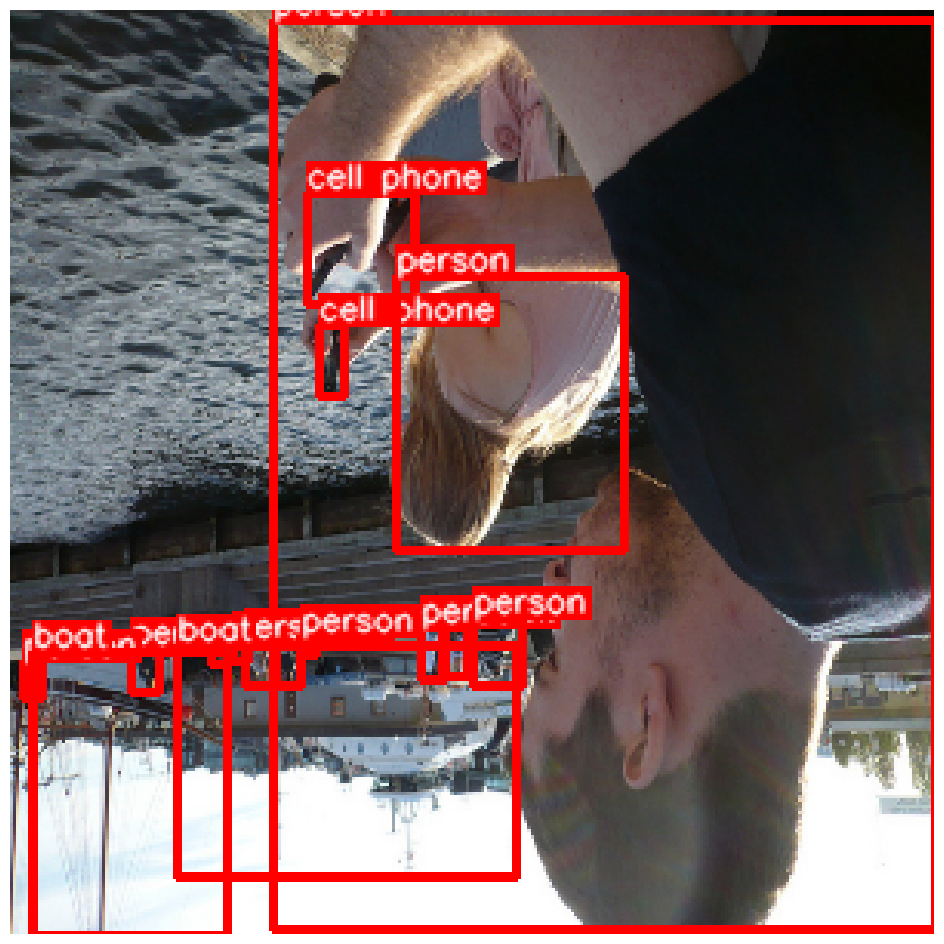

In [13]:
# visualizing one transformed image
img, target = coco_train[8008]

# Convert image to HWC format and denormalize
image = img.permute(1, 2, 0).cpu().numpy()
image = (image * 255).astype(np.uint8)

# Get bounding boxes and labels
bboxes = target['boxes'].cpu().numpy().tolist()
category_ids = target['labels'].cpu().numpy().tolist()

# Visualize
visualize(image, bboxes, category_ids, category_id_to_name)

In [14]:
target

{'boxes': tensor([[ 96.3703,  59.9313, 131.1609,  95.5000],
         [100.2328, 102.4125, 108.4406, 125.8063],
         [ 85.4484,   3.3688, 300.0000, 298.6500],
         [125.4516,  86.5125, 199.6031, 175.9000],
         [140.8641, 200.0813, 148.6969, 216.2063],
         [133.0734, 200.5875, 141.1547, 217.5688],
         [ 76.2281, 204.6750,  85.6641, 219.1562],
         [ 86.6344, 204.4563,  94.6594, 219.2875],
         [ 39.9422, 207.1187,  48.9750, 221.3125],
         [ 65.1750, 206.2812,  70.2937, 212.6375],
         [ 72.8250, 205.5938,  77.3625, 211.1750],
         [150.5063, 197.8562, 166.6219, 219.4500],
         [ 94.6922, 203.6313,  99.7875, 209.2625],
         [  4.6500, 211.0125,  10.8703, 223.0250],
         [ 54.0984, 206.3813, 164.7937, 281.0312],
         [  7.6500, 208.6125,  70.6781, 300.0000]]),
 'labels': tensor([77, 77,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  9,  9]),
 'image_id': tensor([80895])}

# MODEL DEFINITION

In [15]:
# Load the SSD model
num_classes = 91  # COCO dataset has 80 classes + background
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT, progress=True, num_classes=num_classes)

In [16]:
# Check what device is available and print it
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [17]:
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# OPTIMIZER

In [25]:
# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

# TRAINING-PHASE

In [26]:
# Training loop
training_losses = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    # Use tqdm for progress bar
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for images, targets in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            try:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                running_loss += losses.item()

                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                tepoch.set_postfix(loss=losses.item())

            except ValueError as ve:
                continue
            except Exception as e:
                continue

    # Compute the average loss
    avg_loss = running_loss / len(train_dataloader)

    # Store the metrics
    training_losses.append(avg_loss)

    # Print training statistics
    end_time = time.time()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {end_time - start_time:.2f} seconds")

print("Training complete.")

Epoch 1/5: 100%|██████████| 14786/14786 [2:28:14<00:00,  1.66batch/s, loss=5.36]  


Epoch [1/5], Loss: 4.0633, Time: 8894.08 seconds


Epoch 2/5: 100%|██████████| 14786/14786 [2:26:02<00:00,  1.69batch/s, loss=3.52] 


Epoch [2/5], Loss: 3.9042, Time: 8762.12 seconds


Epoch 3/5: 100%|██████████| 14786/14786 [2:25:33<00:00,  1.69batch/s, loss=4.77] 


Epoch [3/5], Loss: 3.8433, Time: 8733.69 seconds


Epoch 4/5: 100%|██████████| 14786/14786 [2:25:35<00:00,  1.69batch/s, loss=3.81] 


Epoch [4/5], Loss: 3.8069, Time: 8735.54 seconds


Epoch 5/5: 100%|██████████| 14786/14786 [2:22:00<00:00,  1.74batch/s, loss=2.79] 

Epoch [5/5], Loss: 3.7709, Time: 8520.01 seconds
Training complete.


# SAVING AND LOADING THE TRAINED MODEL

In [27]:
# Define the model name
model_name = "Sho.pth"

# The path to save the model
model_save_path = r'C:\Users\krish\Documents\Summer\Project\model\Sho.pth'

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully as {model_name}.")

Model saved successfully as Sho.pth.


In [28]:
# Load the model
model.load_state_dict(torch.load(model_save_path))
model.to(device)
print(f"Model loaded successfully from {model_save_path}.")

Model loaded successfully from C:\Users\krish\Documents\Summer\Project\model\Sho.pth.


In [29]:
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# MODEL PERFORMANCE ON VALIDATION DATA

In [30]:
BOX_COLOR = (255, 0, 0) # Red for predictions
TEXT_COLOR = (255, 255, 255) # White
GT_BOX_COLOR = (0, 255, 0) # Green for ground truth

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = [int(coord) for coord in bbox]
    
    # Draw the bounding box
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    # Position for the text label
    text_org = (x_min, y_min - 10 if y_min - 10 > 10 else y_min + 20)
    
    # Background rectangle for text
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img, (text_org[0] - 1, text_org[1] - text_height - 2), 
                  (text_org[0] + text_width + 1, text_org[1] + 2), color, -1)
    
    # Draw the text label
    cv2.putText(img, class_name, text_org, cv2.FONT_HERSHEY_SIMPLEX, 0.5, TEXT_COLOR, thickness=1, lineType=cv2.LINE_AA)
    return img

def visualize_predictions(images, predictions, targets, category_id_to_name, num_images=3):
    for img, prediction, target in zip(images[:num_images], predictions[:num_images], targets[:num_images]):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8)

        # Visualize ground truth
        for bbox, label in zip(target['boxes'].cpu().numpy(), target['labels'].cpu().numpy()):
            class_name = category_id_to_name[label]
            img = visualize_bbox(img, bbox, class_name, color=GT_BOX_COLOR)

        # Visualize predictions
        for bbox, label in zip(prediction['boxes'].cpu().numpy(), prediction['labels'].cpu().numpy()):
            class_name = category_id_to_name[label]
            img = visualize_bbox(img, bbox, class_name, color=BOX_COLOR)

        plt.figure(figsize=(12, 12))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

In [31]:
def validation(model, dataloader, device, num_images=3):
    model.eval()
    predictions = []
    image_ids = []
    images = []
    targets = []

    with torch.no_grad():
        for images_batch, targets_batch in tqdm(dataloader):
            images_batch = list(img.to(device) for img in images_batch)
            outputs = model(images_batch)

            predictions.extend(outputs)
            image_ids.extend([target["image_id"].item() for target in targets_batch])
            images.extend(images_batch)
            targets.extend(targets_batch)
            
            if len(predictions) >= num_images:
                break

    # Load COCO ground truth annotations
    coco_gt = COCO(val_annotations)
    category_id_to_name = {cat['id']: cat['name'] for cat in coco_gt.loadCats(coco_gt.getCatIds())}

    # Visualize predictions and ground truth
    visualize_predictions(images, predictions, targets, category_id_to_name, num_images)

  0%|          | 0/625 [00:01<?, ?it/s]


loading annotations into memory...
Done (t=41.12s)
creating index...
index created!


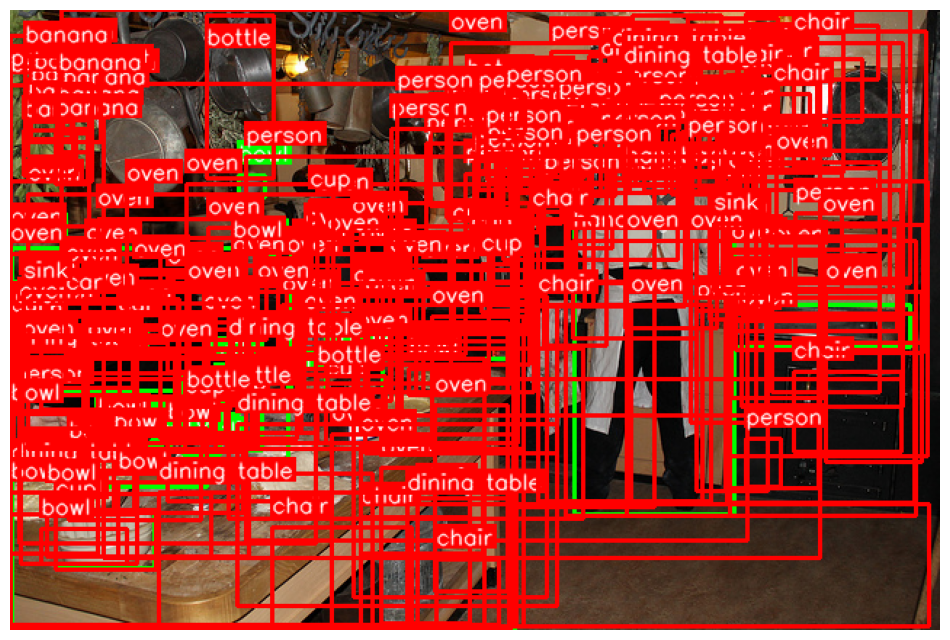

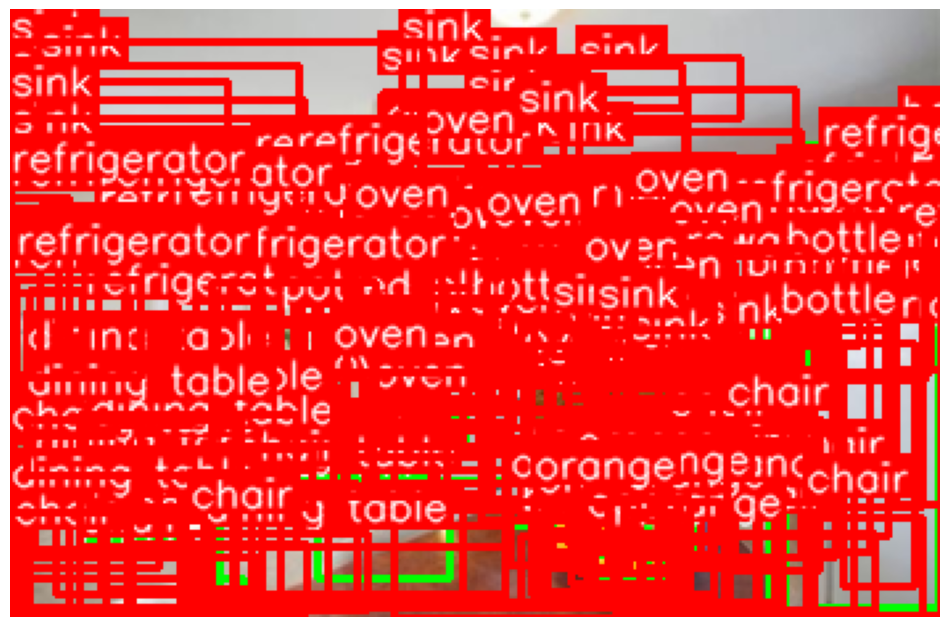

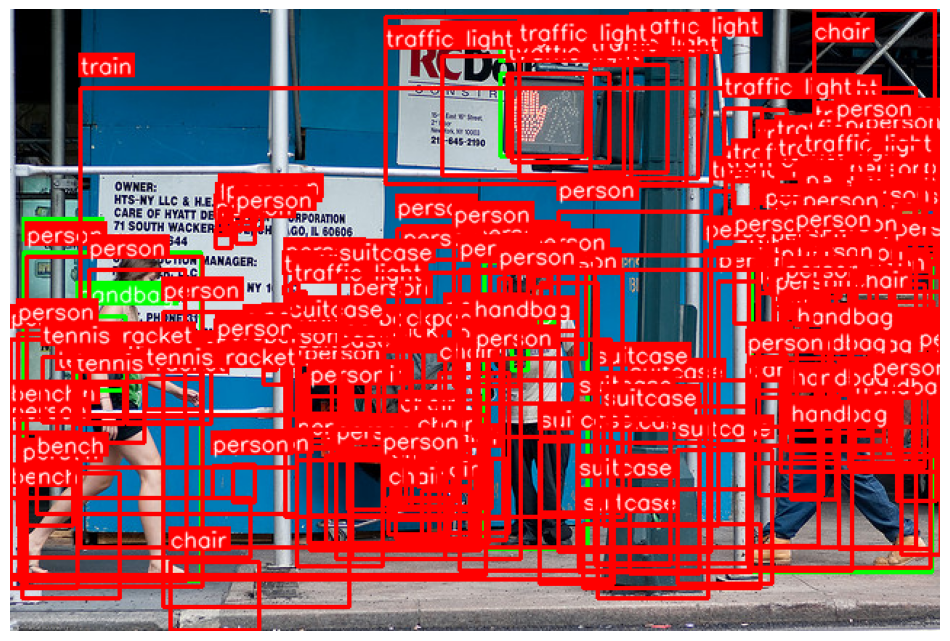

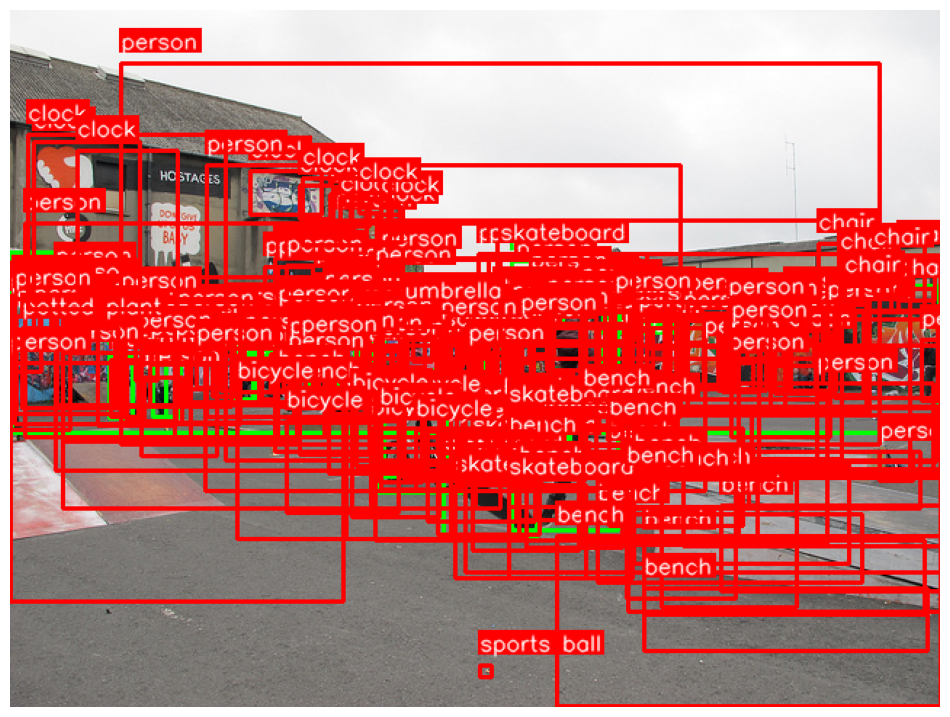

In [33]:
# Perform visualization of a few predictions
validation(model, test_dataloader, device, num_images=4)

# POST-PROCESSING WITH 'NON-MAXIMUM SUPPRESSION'

In [34]:
# Load COCO ground truth annotations
coco_truth = COCO(val_annotations)

loading annotations into memory...
Done (t=1.12s)
creating index...
index created!


In [40]:
def convert_(predictions, image_ids):
    coco_results = []
    for i, prediction in enumerate(predictions):
        boxes = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        image_id = image_ids[i]

        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min


            coco_results.append({
                "image_id": image_id,
                "category_id": label,
                "bbox": [x_min, y_min, width, height],  # Convert to COCO format [x_min, y_min, width, height]
                "score": score,
            })
    return coco_results


In [42]:
def non_max_suppression(predictions, iou_threshold=0.6):
    nms_predictions = []
    for prediction in predictions:
        boxes = prediction['boxes']
        scores = prediction['scores']
        labels = prediction['labels']
        
        keep = nms(boxes, scores, iou_threshold)
        
        nms_predictions.append({
            'boxes': boxes[keep],
            'scores': scores[keep],
            'labels': labels[keep]
        })
    return nms_predictions

def filter_predictions(predictions, score_threshold=0.6):
    filtered_predictions = []
    for prediction in predictions:
        boxes = prediction['boxes']
        scores = prediction['scores']
        labels = prediction['labels']

        keep = scores >= score_threshold

        filtered_predictions.append({
            'boxes': boxes[keep],
            'scores': scores[keep],
            'labels': labels[keep]
        })
    return filtered_predictions

# Apply score filtering during evaluation
def evaluate(model, dataloader, coco_gt, device, score_threshold=0.6, iou_threshold=0.6):
    model.eval()
    predictions = []
    image_ids = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = list(img.to(device) for img in images)
            outputs = model(images)

            filtered_outputs = filter_predictions(outputs, score_threshold)
            nms_outputs = non_max_suppression(filtered_outputs, iou_threshold)

            predictions.extend(nms_outputs)
            image_ids.extend([target["image_id"].item() for target in targets])

    # Convert predictions to COCO format
    coco_results = convert_(predictions, image_ids)

    # Load ground truth COCO annotations
    coco_dt = coco_gt.loadRes(coco_results)

    # Initialize COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

# Perform evaluation
evaluate(model, test_dataloader, coco_truth, device)

100%|██████████| 625/625 [09:27<00:00,  1.10it/s]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=46.88s).
Accumulating evaluation results...
DONE (t=3.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

# MODEL PERFORMANCE ON MY PHONE IMAGES :)

In [43]:
# Load and correct the image orientation
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = img._getexif()
        if exif is not None:
            orientation = exif[orientation]
            if orientation == 3:
                img = img.rotate(180, expand=True)
            elif orientation == 6:
                img = img.rotate(270, expand=True)
            elif orientation == 8:
                img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass

    return img

In [64]:
# List of image paths to process
image_paths = [
    r"C:\Users\krish\Documents\Summer\Project\IMG_1706.jpg",
    r"C:\Users\krish\Documents\Summer\Project\IMG_8.jpg",
    r"C:\Users\krish\Documents\Summer\Project\IMG_13.jpg",
    r"C:\Users\krish\Documents\Summer\Project\IMG_14.jpg",
    r"C:\Users\krish\Documents\Summer\Project\21.jpg",
    r"C:\Users\krish\Documents\Summer\Project\22.jpg",
    r"C:\Users\krish\Documents\Summer\Project\23.jpg",
    r"C:\Users\krish\Documents\Summer\Project\25.jpg"
]

In [65]:
# Visualize predictions with bounding boxes, labels, and scores
def visualize_predictions(image, predictions, category_id_to_name):
    img = image.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

    for bbox, score, label in zip(predictions['boxes'].cpu().numpy(), predictions['scores'].cpu().numpy(), predictions['labels'].cpu().numpy()):
        class_name = category_id_to_name[label]
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (220, 0, 0), 2)
        cv2.putText(img, f'{class_name} {score:.2f}', (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (220, 0, 0), 3)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR back to RGB for visualization
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Predicted Bounding Boxes')
    plt.show()

In [66]:
def process_images(image_paths, model, device, score_threshold=0.6, iou_threshold=0.6):
    transform = T.Compose([T.ToTensor()])
    
    model.eval()

    for image_path in image_paths:
        img = load_image(image_path)
        image = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(image)[0]

        filtered_outputs = filter_predictions([prediction], score_threshold)
        nms_outputs = non_max_suppression(filtered_outputs, iou_threshold)
        
        visualize_predictions(image.squeeze(0), nms_outputs[0], category_id_to_name)

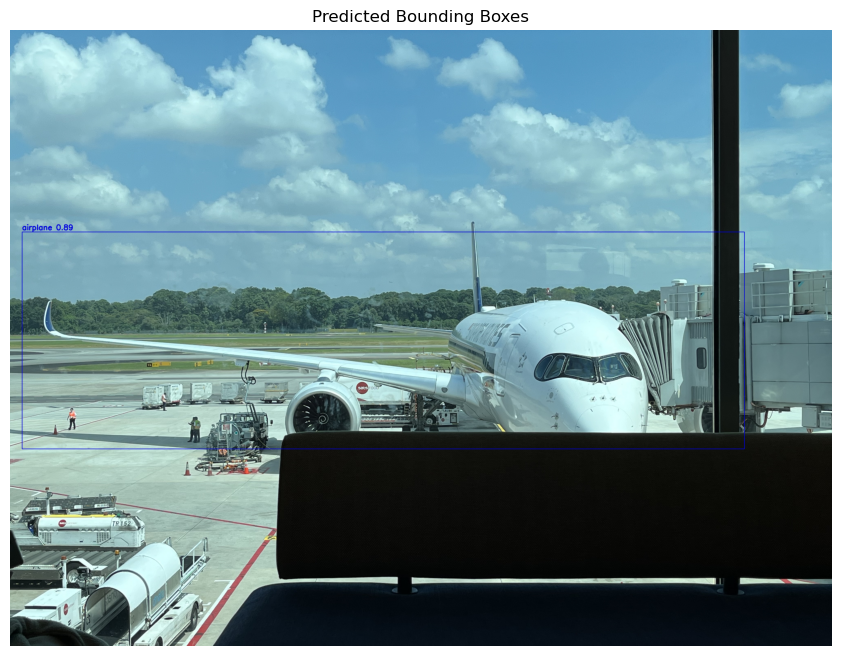

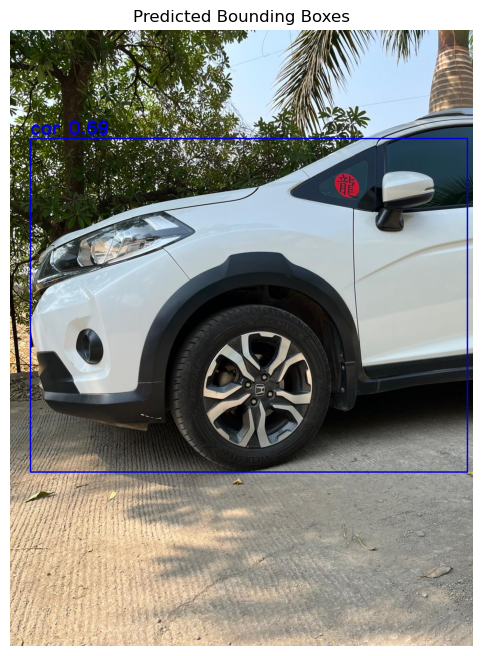

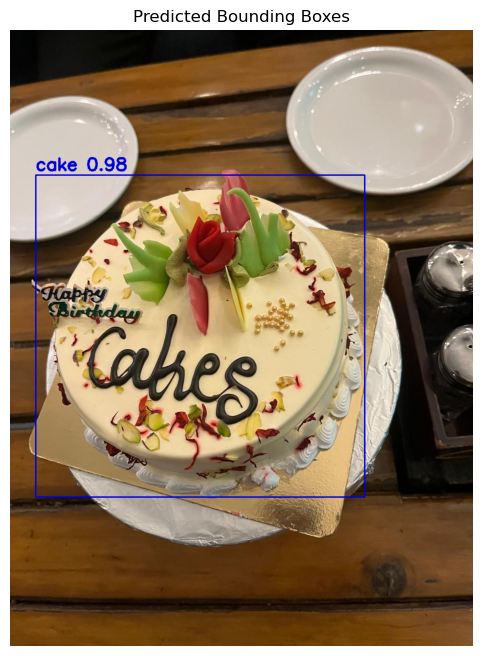

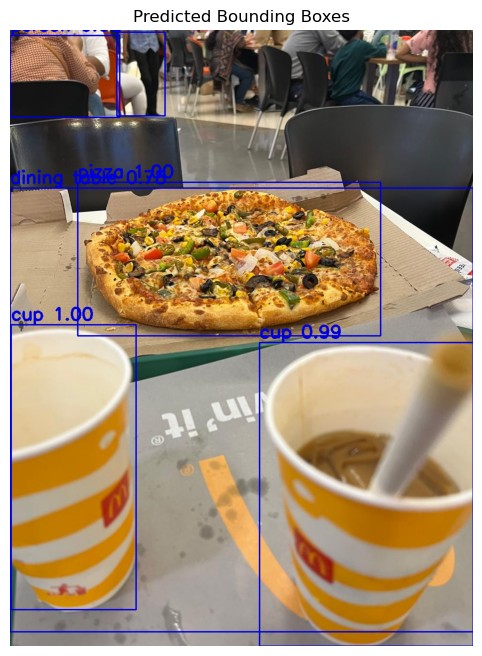

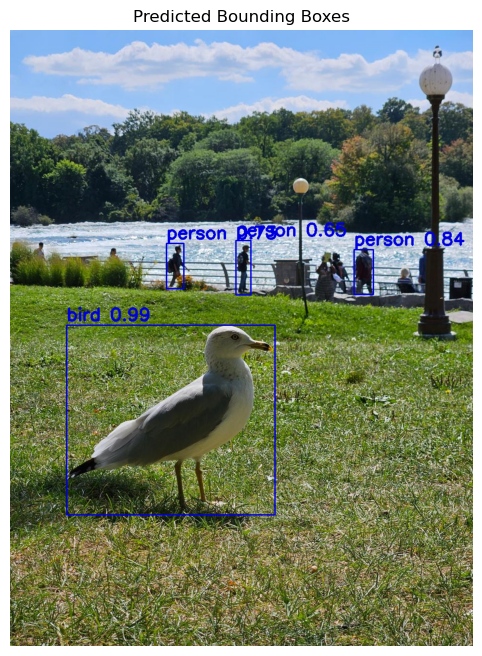

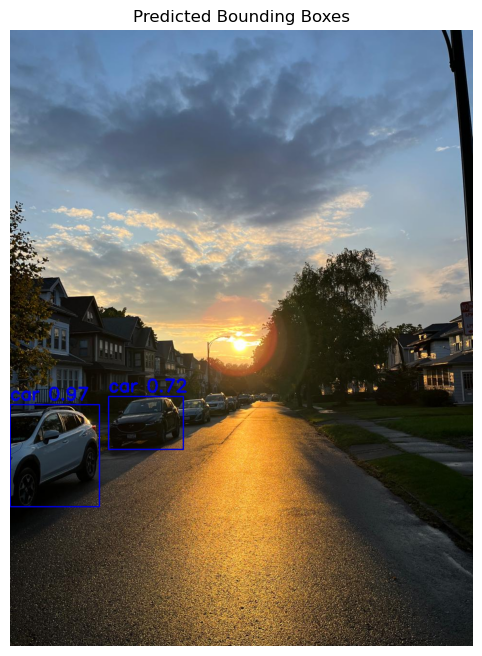

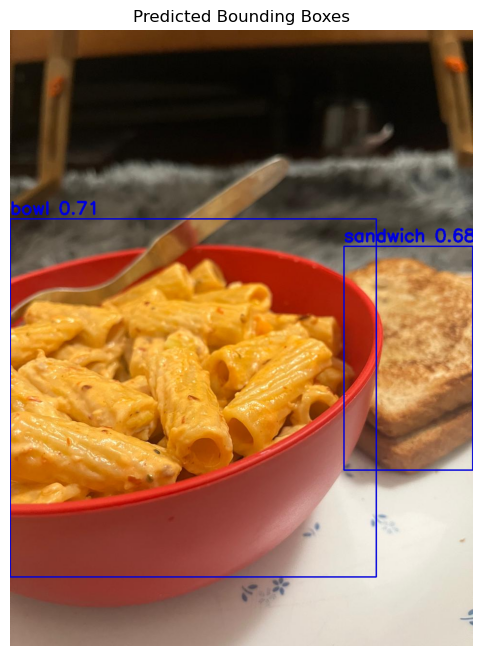

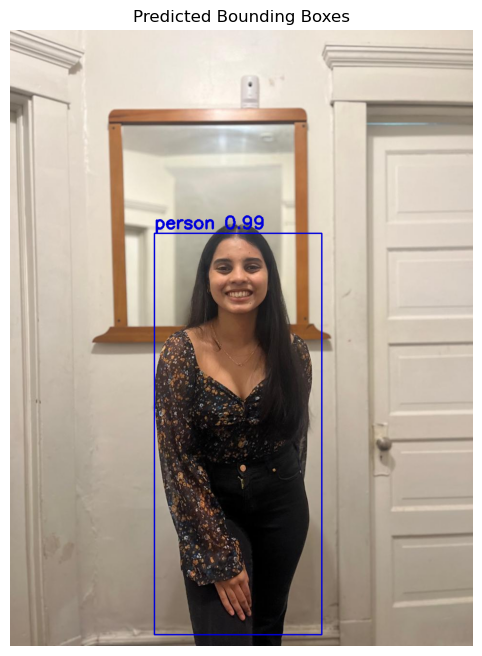

In [67]:
# Process and visualize predictions for the images
process_images(image_paths, model, device)